In [1]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib import cm
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['savefig.dpi'] = 300

LOG_DIR = Path("tournament_games")
EXT = ".log"

RE_START = re.compile(
    r"Starting game:\s*(?P<scenario>.+?)\s*-\s*(?P<polA>[^:]+):\s*(?P<numA>\d+)\s*vs\s*(?P<polB>[^:]+):\s*(?P<numB>\d+)",
    re.IGNORECASE,
)

# Accepts: Winner: Team A | Team B | Draw  (case-insensitive)
RE_END = re.compile(
    r"Ending game:\s*Team\s*a:\s*(?P<scoreA>\d+)\s*,\s*Team\s*b:\s*(?P<scoreB>\d+)\s*,\s*Winner:\s*(?P<winner>(?:Team\s*[AB]|Draw))\s*$",
    re.IGNORECASE,
)

def parse_log(path: Path):
    start_m = end_m = None
    for line in path.read_text(encoding="utf-8", errors="ignore").splitlines():
        if not start_m and "Starting game:" in line:
            start_m = RE_START.search(line)
        if not end_m and "Ending game:" in line:
            end_m = RE_END.search(line)
        if start_m and end_m:
            break
    if not (start_m and end_m):
        return None

    scenario = start_m.group("scenario").strip()
    polA, polB = start_m.group("polA").strip(), start_m.group("polB").strip()
    numA, numB = int(start_m.group("numA")), int(start_m.group("numB"))
    scoreA, scoreB = int(end_m.group("scoreA")), int(end_m.group("scoreB"))
    winner_raw = end_m.group("winner").strip().lower()

    # Normalize winner to 'A'/'B'/'draw'
    if "draw" in winner_raw:
        winner_norm = "draw"
    elif "a" == winner_raw.replace("team","").strip():
        winner_norm = "A"
    else:
        winner_norm = "B"

    # Order-insensitive policies; align scores to sorted policy order
    policy_1, policy_2 = sorted([polA, polB])
    score_1, score_2 = (scoreA, scoreB) if (policy_1 == polA) else (scoreB, scoreA)

    # Agents label like "2v2" / "4v4" (order-insensitive)
    a, b = sorted([numA, numB])
    agents = f"{a}v{b}"

    # Winner/loser by policy names (handle draw)
    if winner_norm == "draw":
        winner_pol = "draw"
        loser_pol  = "draw"
    else:
        winner_pol = policy_1 if (winner_norm == "A" and policy_1 == polA) or (winner_norm == "B" and policy_2 == polB) else policy_2
        loser_pol  = policy_2 if winner_pol == policy_1 else policy_1

    return {
        "agents": agents,
        "policy_1": policy_1,
        "policy_2": policy_2,
        "scenario": scenario,
        "score_1": score_1,
        "score_2": score_2,
        "winner": winner_pol,
        "loser": loser_pol,
        "logfile": str(path),
    }

rows, failed = [], []
for p in LOG_DIR.rglob(f"*{EXT}"):
    if not p.is_file():
        continue
    rec = parse_log(p)
    (rows if rec else failed).append(rec or str(p))

df = pd.DataFrame(rows)
print(f"Parsed: {len(df)}  |  Failed: {len(failed)}")
df.head()

Parsed: 71  |  Failed: 0


,agents,policy_1,policy_2,scenario,score_1,score_2,winner,loser,logfile
0,2v2,free_simple,regional_simple,default_scenario,2,11,free_simple,regional_simple,tournament_games\default_scenario--free_simple...
1,2v2,free_simple,regional_simple,default_scenario,2,7,free_simple,regional_simple,tournament_games\default_scenario--free_simple...
2,2v2,free_simple,two_capped_neural,default_scenario,0,4,free_simple,two_capped_neural,tournament_games\default_scenario--free_simple...
3,2v2,free_simple,two_capped_neural,default_scenario,1,2,free_simple,two_capped_neural,tournament_games\default_scenario--free_simple...
4,2v2,long_short,regional_simple,default_scenario,1,1,draw,draw,tournament_games\default_scenario--long_short_...


In [2]:
# 1) winner / loser with draw handling
def _win_lose_row(r):
    if r["score_1"] > r["score_2"]:
        return pd.Series({"winner": r["policy_1"], "loser": r["policy_2"]})
    elif r["score_2"] > r["score_1"]:
        return pd.Series({"winner": r["policy_2"], "loser": r["policy_1"]})
    else:
        return pd.Series({"winner": "draw", "loser": "draw"})

df[["winner","loser"]] = df.apply(_win_lose_row, axis=1)

# 2) per-policy score columns (NaN for non-participants)
all_policies = sorted(set(df["policy_1"]) | set(df["policy_2"]))

for pol in all_policies:
    # contribution from each side if that side used this policy
    s1 = np.where(df["policy_1"] == pol, df["score_1"], 0)
    s2 = np.where(df["policy_2"] == pol, df["score_2"], 0)
    scores = s1 + s2                     # sums if same policy on both sides
    played = (df["policy_1"] == pol) | (df["policy_2"] == pol)
    col = f"{pol}"
    df[col] = np.where(played, scores, np.nan)


df.head()

,agents,policy_1,policy_2,scenario,score_1,score_2,winner,loser,logfile,free_simple,long_short,regional_simple,short,simple,two_capped_neural
0,2v2,free_simple,regional_simple,default_scenario,2,11,regional_simple,free_simple,tournament_games\default_scenario--free_simple...,2.0,NaN,11.0,NaN,NaN,NaN
1,2v2,free_simple,regional_simple,default_scenario,2,7,regional_simple,free_simple,tournament_games\default_scenario--free_simple...,2.0,NaN,7.0,NaN,NaN,NaN
2,2v2,free_simple,two_capped_neural,default_scenario,0,4,two_capped_neural,free_simple,tournament_games\default_scenario--free_simple...,0.0,NaN,NaN,NaN,NaN,4.0
3,2v2,free_simple,two_capped_neural,default_scenario,1,2,two_capped_neural,free_simple,tournament_games\default_scenario--free_simple...,1.0,NaN,NaN,NaN,NaN,2.0
4,2v2,long_short,regional_simple,default_scenario,1,1,draw,draw,tournament_games\default_scenario--long_short_...,NaN,1.0,1.0,NaN,NaN,NaN


In [3]:
policies = set(df['policy_1'].unique())
policies.update(set(df['policy_2'].unique()))
policies

{'free_simple',
 'long_short',
 'regional_simple',
 'short',
 'simple',
 'two_capped_neural'}

In [9]:
df2 = df[df['agents'] == '2v2'].drop(columns=['agents'])
df4 = df[df['agents'] == '4v4'].drop(columns=['agents', 'free_simple', 'two_capped_neural'])

In [23]:
def compute_play_count(df):
    play_count = {'policy': [], 'played': [], 'wins': [], 'loses': [], 'draws': []}
    policies = set(df['policy_1'].unique())
    policies.update(set(df['policy_2'].unique()))
    for policy in policies:
        play_count['policy'].append(policy)
        played = len(df[df[policy].notna()])
        play_count['played'].append(played)
        wins = len(df[df['winner'] == policy])
        play_count['wins'].append(wins)
        loses = len(df[df['loser'] == policy])
        play_count['loses'].append(loses)
        play_count['draws'].append(played - wins - loses)
    return pd.DataFrame(play_count)

print("### 2v2 ###")
display(compute_play_count(df2))
print("### 4v4 ###")
display(compute_play_count(df4))

### 2v2 ###


,policy,played,wins,loses,draws
0,long_short,22,13,6,3
1,regional_simple,33,9,18,6
2,short,10,6,3,1
3,free_simple,8,2,5,1
4,simple,10,2,8,0
5,two_capped_neural,35,19,11,5


### 4v4 ###


,policy,played,wins,loses,draws
0,short,6,5,1,0
1,simple,2,2,0,0
2,long_short,8,0,8,0
3,regional_simple,8,5,3,0


In [26]:
def compute_board_count(df):
    policies = set(df['policy_1'].unique())
    policies.update(set(df['policy_2'].unique()))
    board_count = {'policy': [], 'default': [], 'small': [], 'large': [], 'wide': []}
    for policy in policies:
        board_count['policy'].append(policy)
        policy_df = df[(df['policy_1'] == policy) | (df['policy_2'] == policy)]
        default_count = len(policy_df[policy_df['scenario'] == 'default_scenario'])
        board_count['default'].append(default_count)
        small_count = len(policy_df[policy_df['scenario'] == 'small_scenario'])
        board_count['small'].append(small_count)
        large_count = len(policy_df[policy_df['scenario'] == 'large_scenario'])
        board_count['large'].append(large_count)
        wide_count = len(policy_df[policy_df['scenario'] == 'wide_scenario'])
        board_count['wide'].append(wide_count)
    return pd.DataFrame(board_count)

print("### 2v2 ###")
display(compute_board_count(df2))
print("### 4v4 ###")
display(compute_board_count(df4).drop(columns=['small', 'wide']))

### 2v2 ###


,policy,default,small,large,wide
0,long_short,14,4,2,2
1,regional_simple,22,6,3,2
2,short,10,0,0,0
3,free_simple,8,0,0,0
4,simple,10,0,0,0
5,two_capped_neural,20,6,5,4


### 4v4 ###


,policy,default,large
0,short,4,2
1,simple,2,0
2,long_short,6,2
3,regional_simple,4,4


In [28]:
def compute_vs_stats(df, policy_name):
    rows = df[(df['policy_1'] == policy_name) | (df['policy_2'] == policy_name)]
    
    opponents = {}
    for _, row in rows.iterrows():
        if row['policy_1'] == policy_name:
            opp = row['policy_2']
            diff = row['score_1'] - row['score_2']
            win = (row['winner'] == policy_name)
        else:
            opp = row['policy_1']
            diff = row['score_2'] - row['score_1']
            win = (row['winner'] == policy_name)
        
        if opp not in opponents:
            opponents[opp] = {'diffs': [], 'wins': 0}
        opponents[opp]['diffs'].append(diff)
        opponents[opp]['wins'] += int(win)

    table = []
    for opp, data in opponents.items():
        diffs = np.array(data['diffs'])
        games = len(diffs)
        table.append({
            "Opponent": opp,
            "Games": games,
            "Win-Rate": data['wins'] / games,
            "Mean Score Diff": np.mean(diffs),
            "Std Score Diff": np.std(diffs),
        })
    return pd.DataFrame(table).sort_values("Mean Score Diff", ascending=False)

In [29]:
# 2v2 Neural
neural_2v2_table = compute_vs_stats(df2, "two_capped_neural")
print("### Neural Policy — 2v2 ###")
display(neural_2v2_table)

# 2v2 Long-Short
long_short_2v2_table = compute_vs_stats(df2, "long_short")
print("### Long-Short — 2v2 ###")
display(long_short_2v2_table)

# 4v4 Long-Short
print("### Long-Short — 4v4 ###")
long_short_4v4_table = compute_vs_stats(df4, "long_short")
display(long_short_4v4_table)

### Neural Policy — 2v2 ###


,Opponent,Games,Win-Rate,Mean Score Diff,Std Score Diff
4,simple,4,1.000000,4.000000,0.000000
2,regional_simple,13,0.615385,3.538462,4.877190
0,free_simple,4,0.750000,1.750000,1.479020
1,long_short,10,0.300000,-2.400000,5.553377
3,short,4,0.250000,-3.750000,3.561952


### Long-Short — 2v2 ###


,Opponent,Games,Win-Rate,Mean Score Diff,Std Score Diff
3,two_capped_neural,10,0.6,2.400,5.553377
2,simple,2,1.0,2.000,1.000000
0,regional_simple,8,0.5,0.375,1.316957
1,short,2,0.5,0.000,2.000000


### Long-Short — 4v4 ###


,Opponent,Games,Win-Rate,Mean Score Diff,Std Score Diff
2,simple,2,0.0,-1.00,0.000000
1,short,2,0.0,-2.00,0.000000
0,regional_simple,4,0.0,-5.25,3.031089


In [30]:
def scenario_stats(df, policy_name):
    rows = df[(df["policy_1"] == policy_name) | (df["policy_2"] == policy_name)]
    scenarios = rows["scenario"].unique()

    data = []
    for sc in scenarios:
        sub = rows[rows["scenario"] == sc]
        games = len(sub)
        if games == 0: continue

        diffs = []
        wins = 0

        for _, r in sub.iterrows():
            if r["policy_1"] == policy_name:
                diff = r["score_1"] - r["score_2"]
                win = (r["winner"] == policy_name)
            else:
                diff = r["score_2"] - r["score_1"]
                win = (r["winner"] == policy_name)

            diffs.append(diff)
            wins += int(win)

        diffs = np.array(diffs)
        data.append({
            "Scenario": sc,
            "Games": games,
            "Win-Rate": wins / games,
            "Mean Score Diff": np.mean(diffs),
            "Std Score Diff": np.std(diffs),
        })

    return pd.DataFrame(data).sort_values("Scenario")


print("### Neural (2v2) by Scenario ###")
display(scenario_stats(df2, "two_capped_neural"))

print("### Long-Short (2v2) by Scenario ###")
display(scenario_stats(df2, "long_short"))

print("### Long-Short (4v4) by Scenario ###")
display(scenario_stats(df4, "long_short"))


### Neural (2v2) by Scenario ###


,Scenario,Games,Win-Rate,Mean Score Diff,Std Score Diff
0,default_scenario,20,0.45,-0.75,4.907902
1,large_scenario,5,0.40,-0.60,3.322650
2,small_scenario,6,1.00,7.50,4.272002
3,wide_scenario,4,0.50,0.75,2.772634


### Long-Short (2v2) by Scenario ###


,Scenario,Games,Win-Rate,Mean Score Diff,Std Score Diff
0,default_scenario,14,0.642857,2.071429,4.350111
1,large_scenario,2,0.500000,3.000000,3.000000
2,small_scenario,4,0.250000,-2.000000,1.870829
3,wide_scenario,2,1.000000,2.000000,0.000000


### Long-Short (4v4) by Scenario ###


,Scenario,Games,Win-Rate,Mean Score Diff,Std Score Diff
0,default_scenario,6,0.0,-3.166667,2.793842
1,large_scenario,2,0.0,-4.000000,3.000000


C:\Users\USER\AppData\Local\Temp\ipykernel_2688\451009863.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = cm.get_cmap(cmap).copy()
C:\Users\USER\AppData\Local\Temp\ipykernel_2688\451009863.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = cm.get_cmap(cmap).copy()


,short,simple,regional_simple,long_short
short,0,0,4,2
simple,0,0,0,2
regional_simple,4,0,0,4
long_short,2,2,4,0


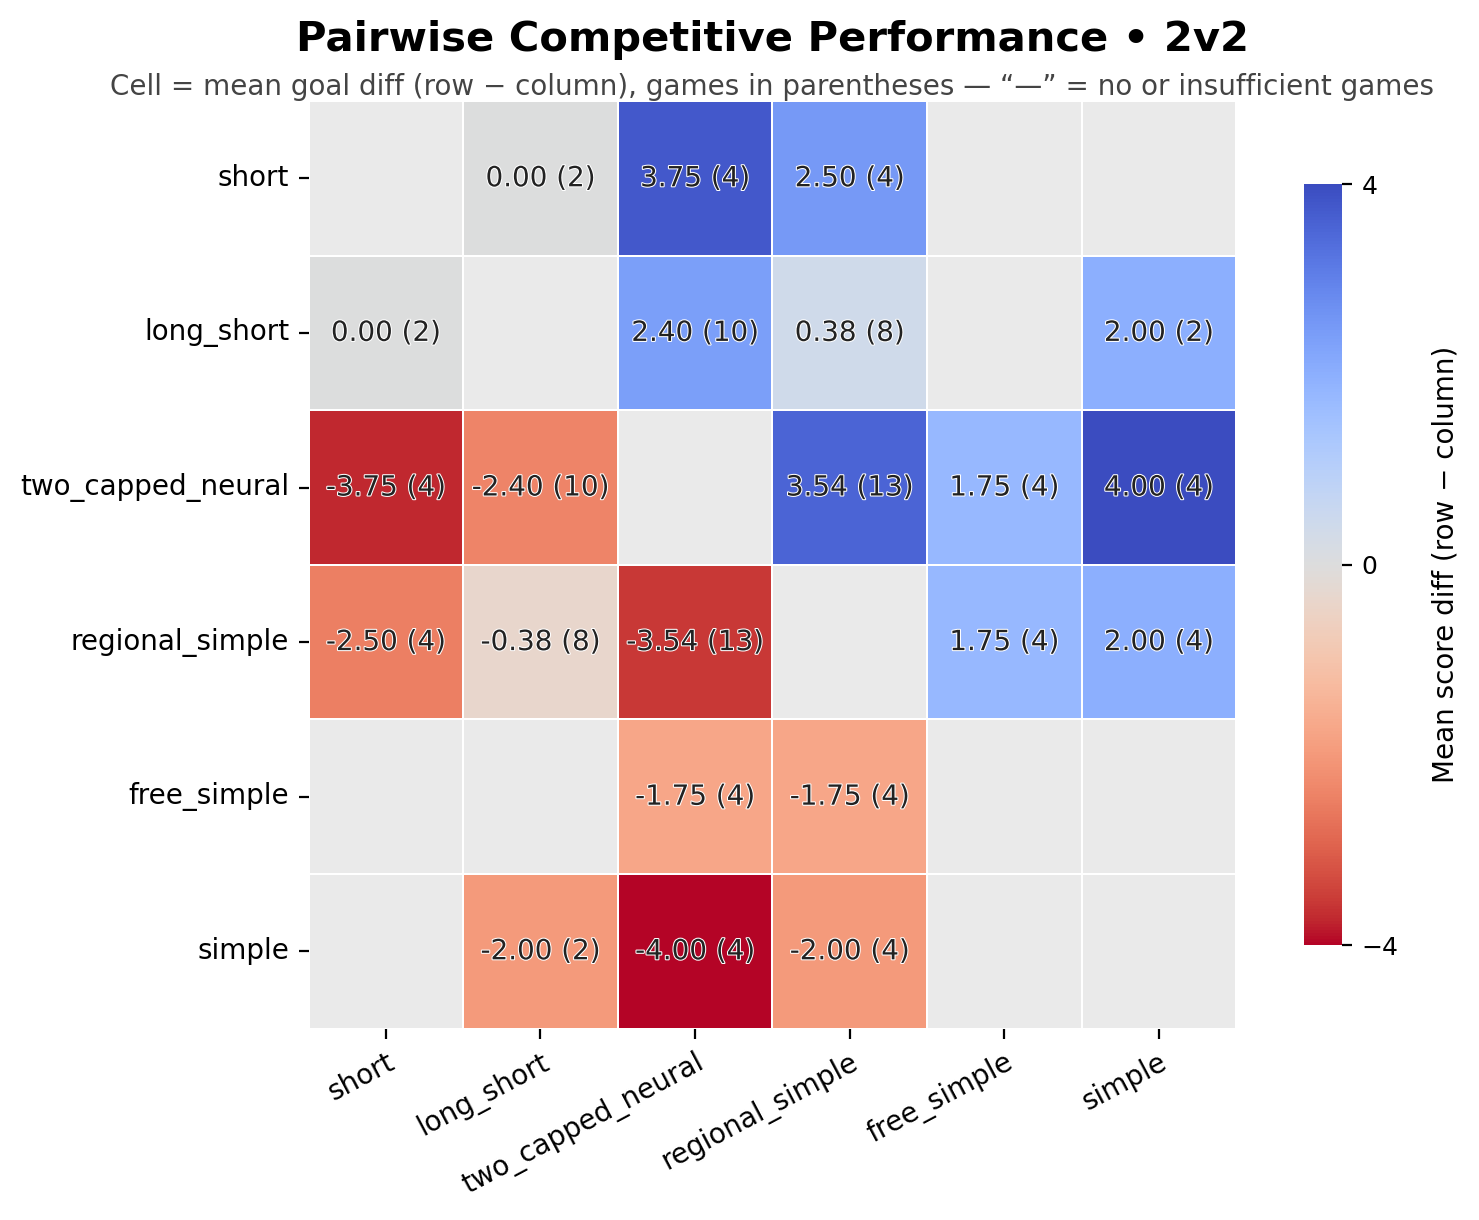

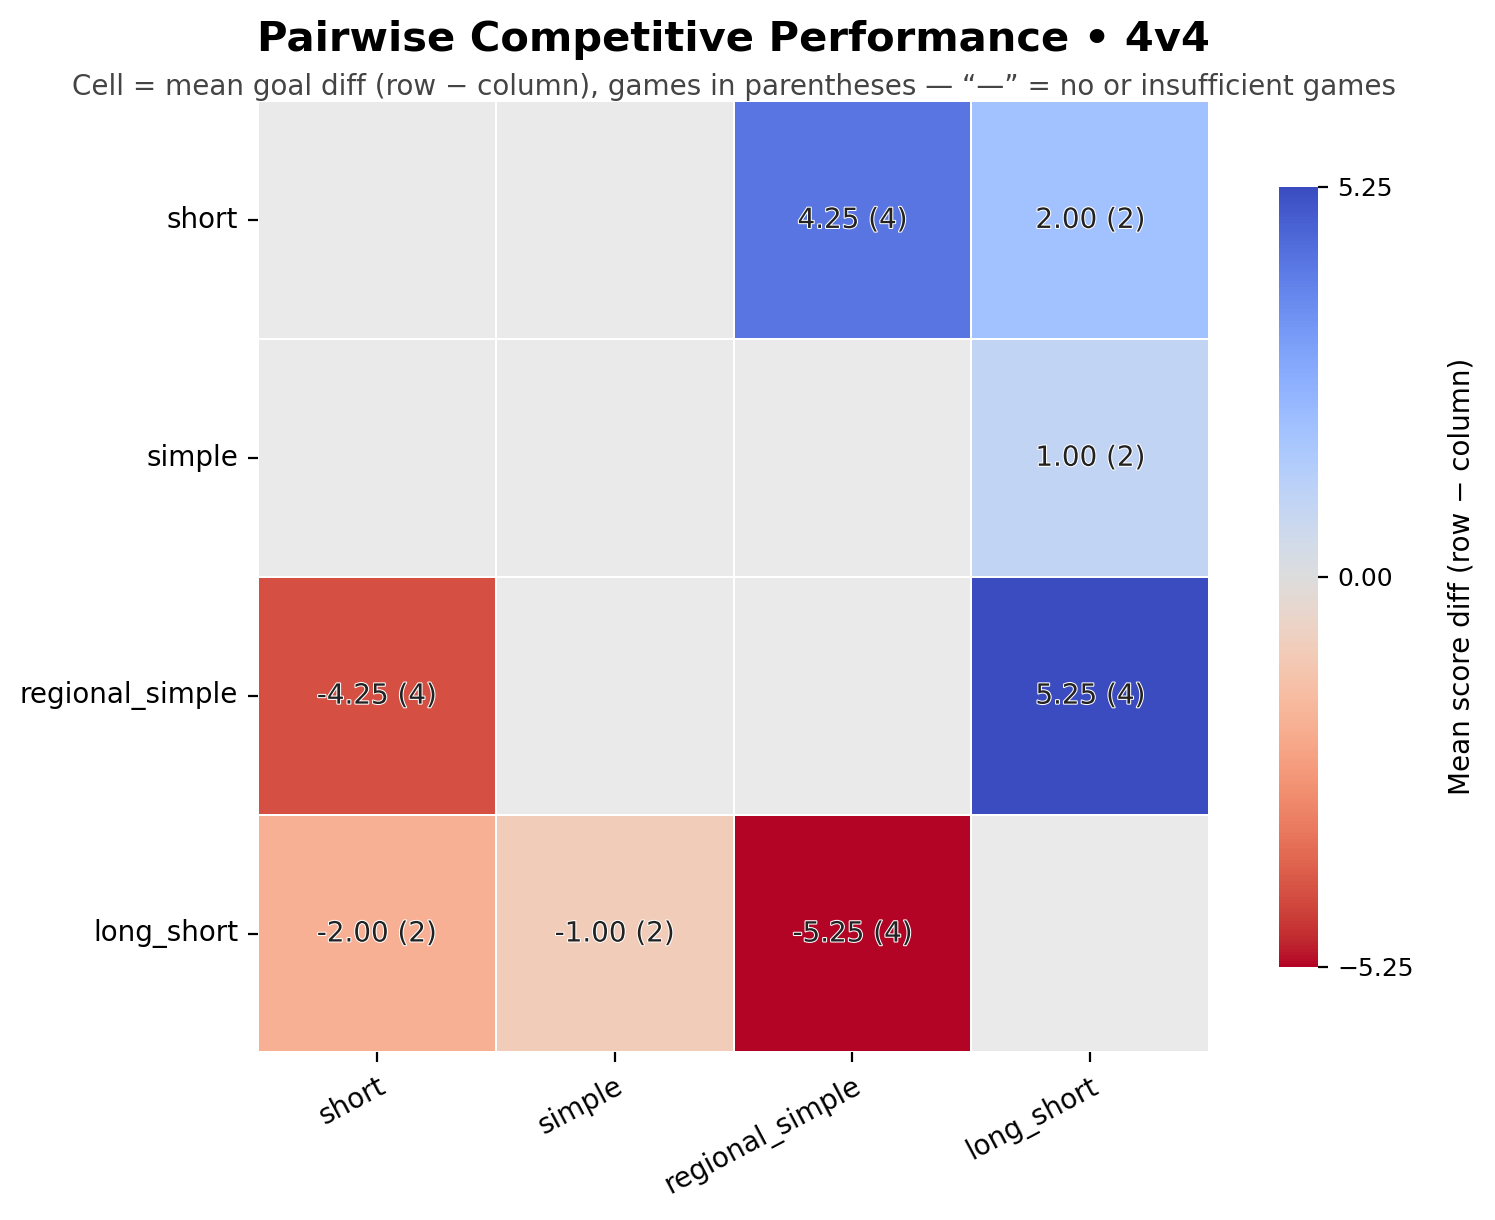

In [36]:
def comp_heatmap(
    df,
    cmap="coolwarm_r",
    digits=2,
    min_games=2,
    title=None,
    figsize=(8.2, 6.2),
    dark=False,                # default now: white theme
    order="auto",
    policy_labels=None,
    team_tag=None
):
    # --- infer policies ---
    found = set(df["policy_1"].dropna().unique()) | set(df["policy_2"].dropna().unique())
    pols = [p for p in found if p in df.columns]

    # labels
    xlabels = [policy_labels.get(p, p) if policy_labels else p for p in pols]

    # aggregate
    S = pd.DataFrame(0.0, index=pols, columns=pols)
    N = pd.DataFrame(0,   index=pols, columns=pols)
    for _, r in df.iterrows():
        p1, p2 = r["policy_1"], r["policy_2"]
        if p1 in pols and p2 in pols:
            d = r[p1] - r[p2]
            S.loc[p1, p2] += d; S.loc[p2, p1] -= d
            N.loc[p1, p2] += 1; N.loc[p2, p1] += 1

    M = S / N.replace(0, np.nan)
    np.fill_diagonal(M.values, np.nan)

    # order by strength
    if order == "auto":
        ord_idx = np.argsort(-np.nanmean(M.values, axis=1))
        pols = list(M.index[ord_idx])
        M, N = M.loc[pols, pols], N.loc[pols, pols]
        xlabels = [policy_labels.get(p, p) if policy_labels else p for p in pols]

    # mask
    diag_mask = pd.DataFrame(np.eye(len(pols), dtype=bool), index=pols, columns=pols)
    mask = (N < min_games) | diag_mask

    T = M.copy().astype(object)
    for i in pols:
        for j in pols:
            if diag_mask.loc[i, j] or (N.loc[i, j] < min_games) or pd.isna(M.loc[i, j]):
                T.loc[i, j] = "—"
            else:
                T.loc[i, j] = f"{M.loc[i, j]:.{digits}f} ({int(N.loc[i, j])})"

    # symmetric color scaling
    vmax = float(np.nanmax(np.abs(M.values))) if np.isfinite(np.nanmax(np.abs(M.values))) else 1
    vmax = vmax if vmax != 0 else 1
    vmin = -vmax

    cmap_obj = cm.get_cmap(cmap).copy()
    cmap_obj.set_bad("#eaeaea")

    # figure
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white")

    ax = sns.heatmap(
        M, mask=mask, cmap=cmap_obj, vmin=vmin, vmax=vmax, center=0,
        annot=T, fmt="", cbar=True, square=True,
        linewidths=0.7, linecolor="white",
        annot_kws={"ha": "center", "va": "center", "fontsize": 10, "color": "#222"},
        cbar_kws={"shrink": 0.82}
    )

    for txt in ax.texts:
        txt.set_path_effects([pe.withStroke(linewidth=0.75, foreground="white")])

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(xlabels, rotation=28, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(xlabels, rotation=0)

    for s in ax.spines.values(): s.set_visible(False)

    # colorbar labeling
    cbar = ax.collections[0].colorbar
    cbar.set_label("Mean score diff (row − column)", rotation=90, labelpad=12)
    cbar.set_ticks([vmin, 0, vmax])
    cbar.ax.tick_params(labelsize=9)

    # title
    if title is None:
        title = "Pairwise Competitive Performance"
        if team_tag:
            title += f" • {team_tag}"

    ax.set_title(title, fontsize=15, pad=18, weight="bold")

    # subtitle placed below title, not overlapping matrix
    subtitle = "Cell = mean goal diff (row − column), games in parentheses — “—” = no or insufficient games"
    ax.text(
        0.5, 1.0, subtitle,
        transform=ax.transAxes,
        fontsize=10, ha="center", va="bottom", color="#444"
    )

    plt.tight_layout()
    return N


comp_heatmap(df2, team_tag="2v2")
comp_heatmap(df4, team_tag="4v4")

In [37]:
import math
from collections import defaultdict

def compute_elo(df, base=1000, k=20):
    elo = defaultdict(lambda: base)
    for _, r in df.iterrows():
        p1, p2 = r["policy_1"], r["policy_2"]
        s1, s2 = r["score_1"], r["score_2"]
        if s1 > s2:
            a1, a2 = 1.0, 0.0
        elif s1 < s2:
            a1, a2 = 0.0, 1.0
        else:
            a1, a2 = 0.5, 0.5
        e1 = 1/(1+10**((elo[p2]-elo[p1])/400))
        e2 = 1-e1
        elo[p1] += k*(a1-e1)
        elo[p2] += k*(a2-e2)
    return pd.Series(dict(elo)).sort_values(ascending=False)
print("2v2:")
display(compute_elo(df2))
print("4v4:")
display(compute_elo(df4))

2v2:


two_capped_neural    1058.419585
long_short           1056.571388
short                1023.687216
free_simple           975.448251
regional_simple       943.908927
simple                941.964633
dtype: float64

4v4:


short              1038.118660
simple             1017.840781
regional_simple    1014.192897
long_short          929.847662
dtype: float64